# Section 1
Explore data in `ecom_data.csv`

## Load

In [2]:
import pandas as pd
from datetime import date

# load raw data
df = pd.read_csv(
    'ecom_data.csv',
    dtype={
        'SalesOrder': str,
        'SKU': str,
        'Description': str,
        'UnitPrice': float,
        'CustomerID': int,
        'Channel': str,
        'State': str,
        'Sales': float,
        'Quantity': int
    },
    converters={
        'InvoiceDay': date.fromisoformat
    })

# drop duplicates
df.drop_duplicates(inplace=True)

# remove rows with Quantity == 0
df = df[df.Quantity != 0].reset_index(drop=True)

To recap the findings in `initial_eda_and_cleaning.ipynb`, I've determined the fields are:
- `SalesOrder`: Order ID.
- `SKU`: Product ID.
- `Description`: Product name.
- `UnitPrice`: Price per unit.
- `CustomerID`: Customer ID.
- `Channel`: Sales channel for sale.
- `State`: State sale was made in/where customer purchased it.
- `Sales`: Total amount for sale.
- `Quantity`: Number of units sold.

Sales with negative `Sales` and `Quantity` values are refunds.

## EDA
### Time Frame

In [3]:
print(f"Data ranges from {df.InvoiceDay.min()} to {df.InvoiceDay.max()}")
print(f"For a total of {(df.InvoiceDay.max() - df.InvoiceDay.min()).days} days")

Data ranges from 2010-12-01 to 2011-12-09
For a total of 373 days


In [4]:
# count unique dates in data
df.InvoiceDay.unique().shape[0]

305

So there are missing date values.

### Total Sales

In [5]:
# filter out refunds
df_sales = df[df.Sales > 0].reset_index(drop=True)

print(f"Total sales for time frame: {df_sales.Sales.sum()}")

Total sales for time frame: 17972298.583


Total sales for the time frame were almost 18M, which is pretty good. Let's remove refunds and look at a plot of sales:

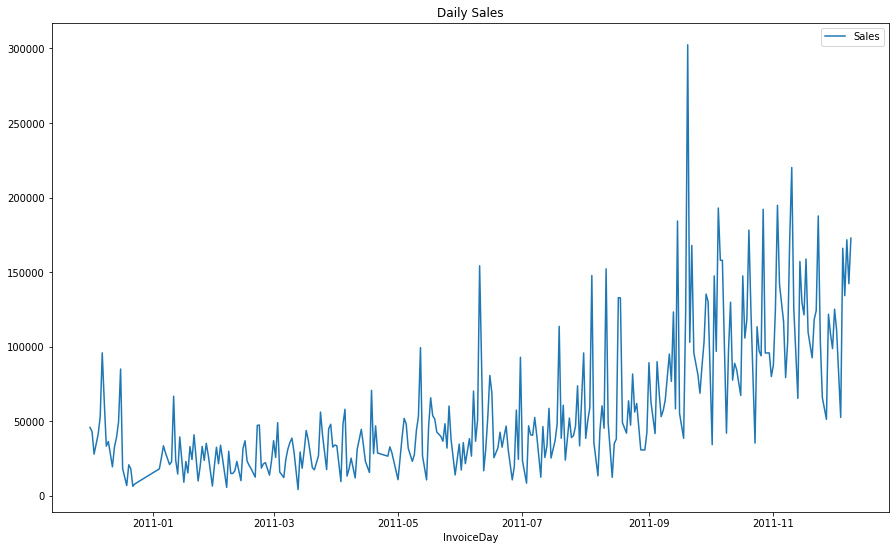

In [6]:
# plot daily sales
ax = df_sales.groupby(['InvoiceDay'])\
    .agg({'Sales': 'sum'})\
    .plot(figsize=(15, 9))
ax.set_title("Daily Sales");

There seems to be an upward trend in sales, which is great. But let's try looking at a 10 day rolling average.

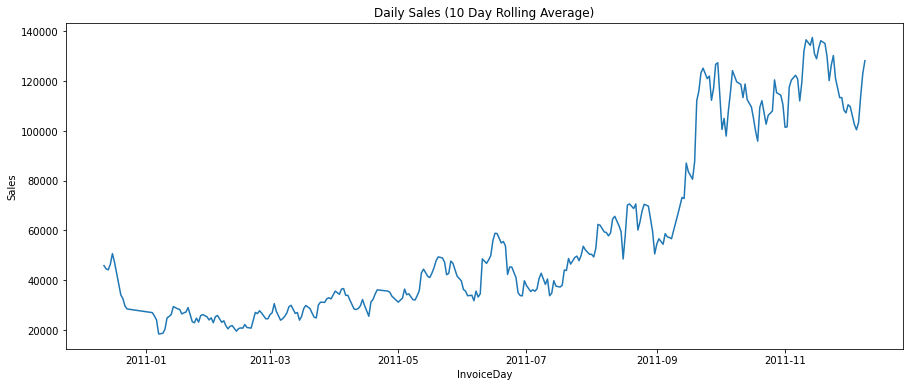

In [20]:
# plot rolling average
ax = df_sales.groupby('InvoiceDay')\
    .agg({'Sales': 'sum'})\
    .rolling(10)\
    .mean()\
    .dropna()\
    .plot(y='Sales', figsize=(15,6));
ax.set_ylabel("Sales")
ax.get_legend().remove()
ax.set_title("Daily Sales (10 Day Rolling Average)");

# save figure
ax.get_figure().savefig("images/sales_10_day_rolling_average.png")

In [27]:
# get year over year increase in sales for first week of December
s1 = df_sales[df_sales.InvoiceDay < date.fromisoformat('2010-12-08')].Sales.sum()
s2 = df_sales[(df_sales.InvoiceDay >= date.fromisoformat('2011-12-01')) &
                (df_sales.InvoiceDay < date.fromisoformat('2011-12-09'))].Sales.sum()
print(f"Year over year increase in sales for 12-01 to 12-09: {round(s2 / s1, 4) * 100}%")

Year over year increase in sales for 12-01 to 12-09: 294.16%


### Channels
First, let's confirm products can be sold via multiple channels:

In [11]:
print(f"SPACEBOY TV DINNER TRAY sold via: {df_sales[df_sales.SKU == '22474'].Channel.unique()}")

SPACEBOY TV DINNER TRAY sold via: ['Mailing' 'Store' 'Organic Social' 'SEO' 'Email']


Next, let's examine the sales amount per channel:

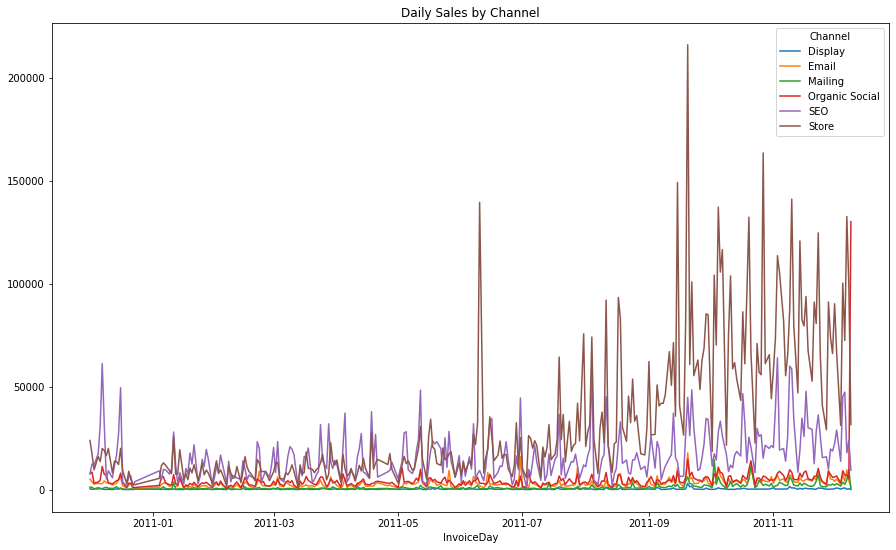

In [8]:
df_sales.groupby(['Channel', 'InvoiceDay'])\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='Channel', values='Sales')\
    .plot(figsize=(15, 9), title="Daily Sales by Channel");

That's pretty noisy. But at a glance, it seems like Store sales have grown to become our largest sales channel, outpacing SEO by an increasingly large margin. There also seems to be a huge amount of variance in store sales, with some curious outliers. Stores and SEO account for the vast majority of sales, while other channels seem to have experienced more stagnant growth.

Let's try looking at a 10 day rolling average.

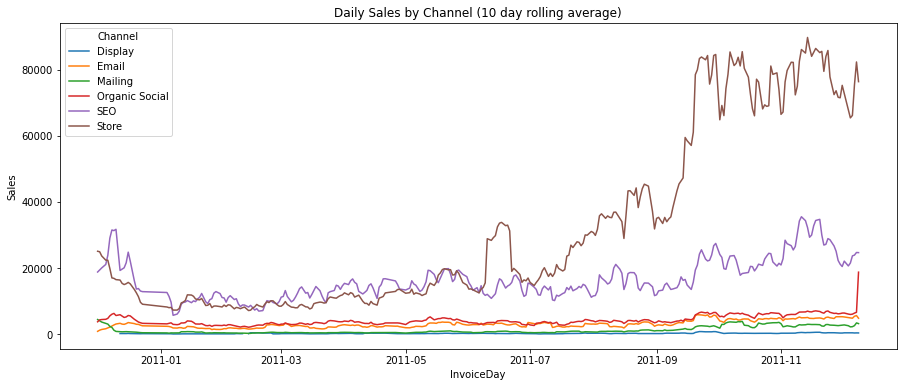

In [40]:
# create rolling average
df_rolling = df_sales.groupby(['Channel', 'InvoiceDay'])\
                .agg({'Sales': 'sum'})\
                .rolling(10)\
                .mean()\
                .dropna()
# create plot
ax = df_rolling.reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='Channel', values='Sales')\
    .plot(figsize=(15, 6), title="Daily Sales by Channel (10 day rolling average)");
ax.set_ylabel("Sales")

# save plot
ax.figure.savefig('images/sales_10_day_rolling_average_by_channel.png');

That's a lot cleaner, and it better illustrates the ascendance of Store sales. We can also see that there's been decent growth in Mailing, and moderate growth in Email and Organic Social. Display seems to be stagnant, and it's unclear how much growth there's been in SEO.

Let's look at this another way:

In [21]:
# group sales by Channel
df_channel = df.groupby(['Channel'])\
    .agg({'Sales': 'sum'})

# add PctTotalSales
df_channel['PctTotalSales'] = (df_channel.Sales / df_channel.Sales.sum()).round(4) * 100
df_channel.sort_values('PctTotalSales', ascending=False)

,Sales,PctTotalSales
Channel,,
Store,9688710.600,56.82
SEO,4842836.353,28.40
Organic Social,1141237.010,6.69
Email,938840.800,5.51
Mailing,358922.760,2.10
Display,81964.570,0.48


So `Store` sales and `SEO` clearly acount for the greatest share. Let's look at it by quarter:

In [29]:
# group sales by Channel, InvoiceDay
df_quarter = df.groupby(['Channel', 'InvoiceDay'])\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)

# add Quarter
df_quarter['Quarter'] = df_quarter.InvoiceDay.apply(lambda d: f"Q{(d.month - 1) // 3 + 1}")

# add Year
df_quarter['Year'] = df_quarter.InvoiceDay.apply(lambda d: d.year)

# filter out values from 2010
df_quarter = df_quarter[df_quarter.Year == 2011].reset_index(drop=True)

# group by Quarter
df_quarter = df_quarter\
    .groupby(['Quarter', 'Channel'])\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)

# add QuarterlySales
df_quarter = df_quarter\
    .set_index('Quarter')\
    .join(df_quarter.groupby('Quarter').agg({'Sales': 'sum'}),
          rsuffix="Quarterly")\
    .reset_index(drop=False)

# add PctSalesQuarterly
df_quarter['PctSalesQuarterly'] = df_quarter.Sales / df_quarter.SalesQuarterly
df_quarter['PctSalesQuarterly'] = df_quarter.PctSalesQuarterly.round(4) * 100

# set index
df_quarter.set_index(['Quarter', 'Channel'], inplace=True)
df_quarter.sort_values(['Quarter', 'PctSalesQuarterly'], ascending=False, inplace=True)

# drop column
df_quarter.drop(columns=['SalesQuarterly'], inplace=True)

In [41]:
df_quarter

Sales  PctSalesQuarterly
Quarter Channel                                       
Q4      Store           4418200.790              66.15
        SEO             1433692.430              21.46
        Organic Social   357802.060               5.36
        Email            271742.760               4.07
        Mailing          175629.730               2.63
        Display           22412.920               0.34
Q3      Store           3184291.240              62.49
        SEO             1231773.060              24.17
        Organic Social   314536.530               6.17
        Email            249339.980               4.89
        Mailing           91638.240               1.80
        Display           24450.520               0.48
Q2      Store           1143944.130              42.61
        SEO             1070450.753              39.87
        Organic Social   208557.390               7.77
        Email            201649.880               7.51
        Mailing           43605.600               1.62
        Display           16512.140               0.62
Q1      SEO              798010.630              42.63
        Store            693578.750              37.05
        Organic Social   169988.800               9.08
        Email            159177.300               8.50
        Mailing           36665.890               1.96
        Display           14630.040               0.78

`Store` grew from 37% of sales in Q1 to 66.15% of sales in Q4, while `Mailing` also increased its share of total sales.

In [24]:
# find growth in sales by Channel between Q1 and Q4
df_growth = pd.DataFrame(df_quarter.loc['Q4'].Sales / df_quarter.loc['Q1'].Sales)
df_growth.rename(columns={'Sales': 'PctGrowth'}, inplace=True)
df_growth['PctGrowth'] = df_growth.PctGrowth.round(4) * 100
df_growth.sort_values('PctGrowth', ascending=False)

,PctGrowth
Channel,
Store,637.02
Mailing,479.00
Organic Social,210.49
SEO,179.66
Email,170.72
Display,153.20


It's hard to infer much from percent growth between Q1 and Q4, as the seasonal trend shows we expect sales in Q4 to be significantly higher. However, it's notable that `Store` and `Mailing` outpaced all other channels in growth.

### States
Let's break it down by location now.

In [25]:
# number of states
df_sales.State.unique().shape[0]

49

In [26]:
# percent of Sales by State
df_state = df_sales\
    .groupby('State')\
    .agg({'Sales': 'sum'})
df_state['PctSales'] = (df_state.Sales / df_state.Sales.sum()).round(4) * 100
df_state.sort_values('PctSales', ascending=False, inplace=True)
df_state.head(15)

,Sales,PctSales
State,,
CA,2476231.300,13.78
TX,1705448.090,9.49
FL,1497986.510,8.33
AL,946440.930,5.27
IL,937609.910,5.22
NY,765825.663,4.26
GA,761671.360,4.24
NC,757156.410,4.21
PA,587860.640,3.27


Unsurprisingly, states with large populations seem to have larger proportions of total sales. Though AL is a bit of an outlier. Let's plot sales by state:

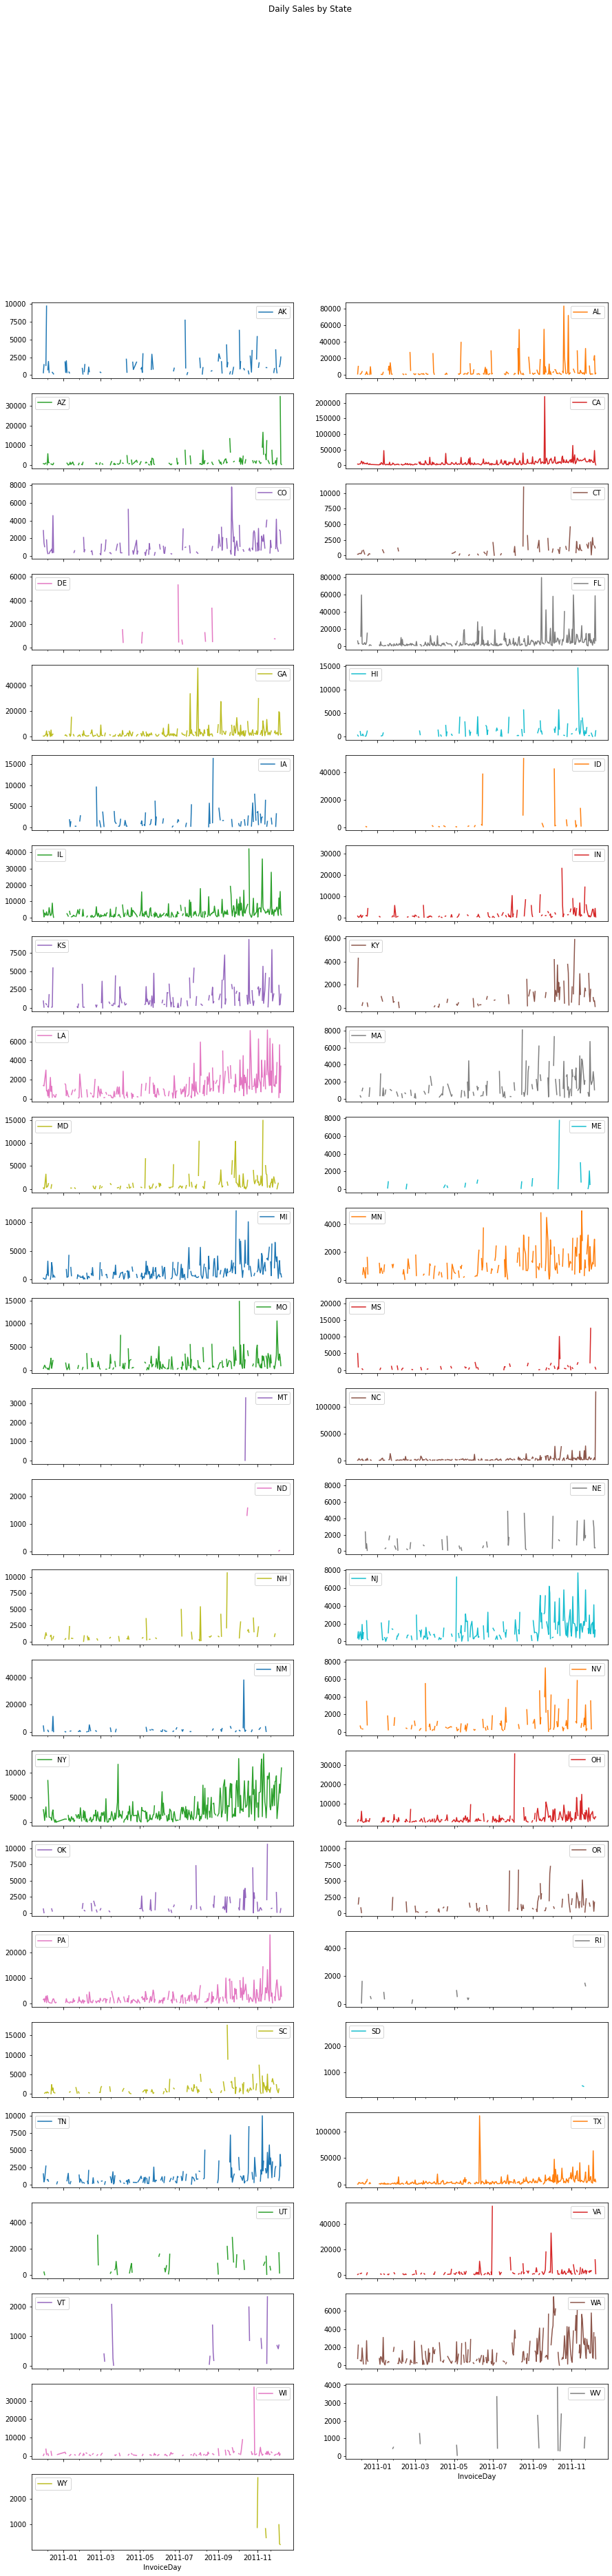

In [27]:
# plot sales by state
df_sales.groupby(['State', 'InvoiceDay'])\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='State', values='Sales')\
    .plot(figsize=(15, 60), subplots=True, layout=(25, 2), title="Daily Sales by State");

Interestingly, some states have large gaps in sales. Since stores are such a big channel, this might suggest that they don't have stores (or if they do, not very active ones) and that sales for such states come from other channels.

Since stores are so important though, let's take a look at the Store channel by location:

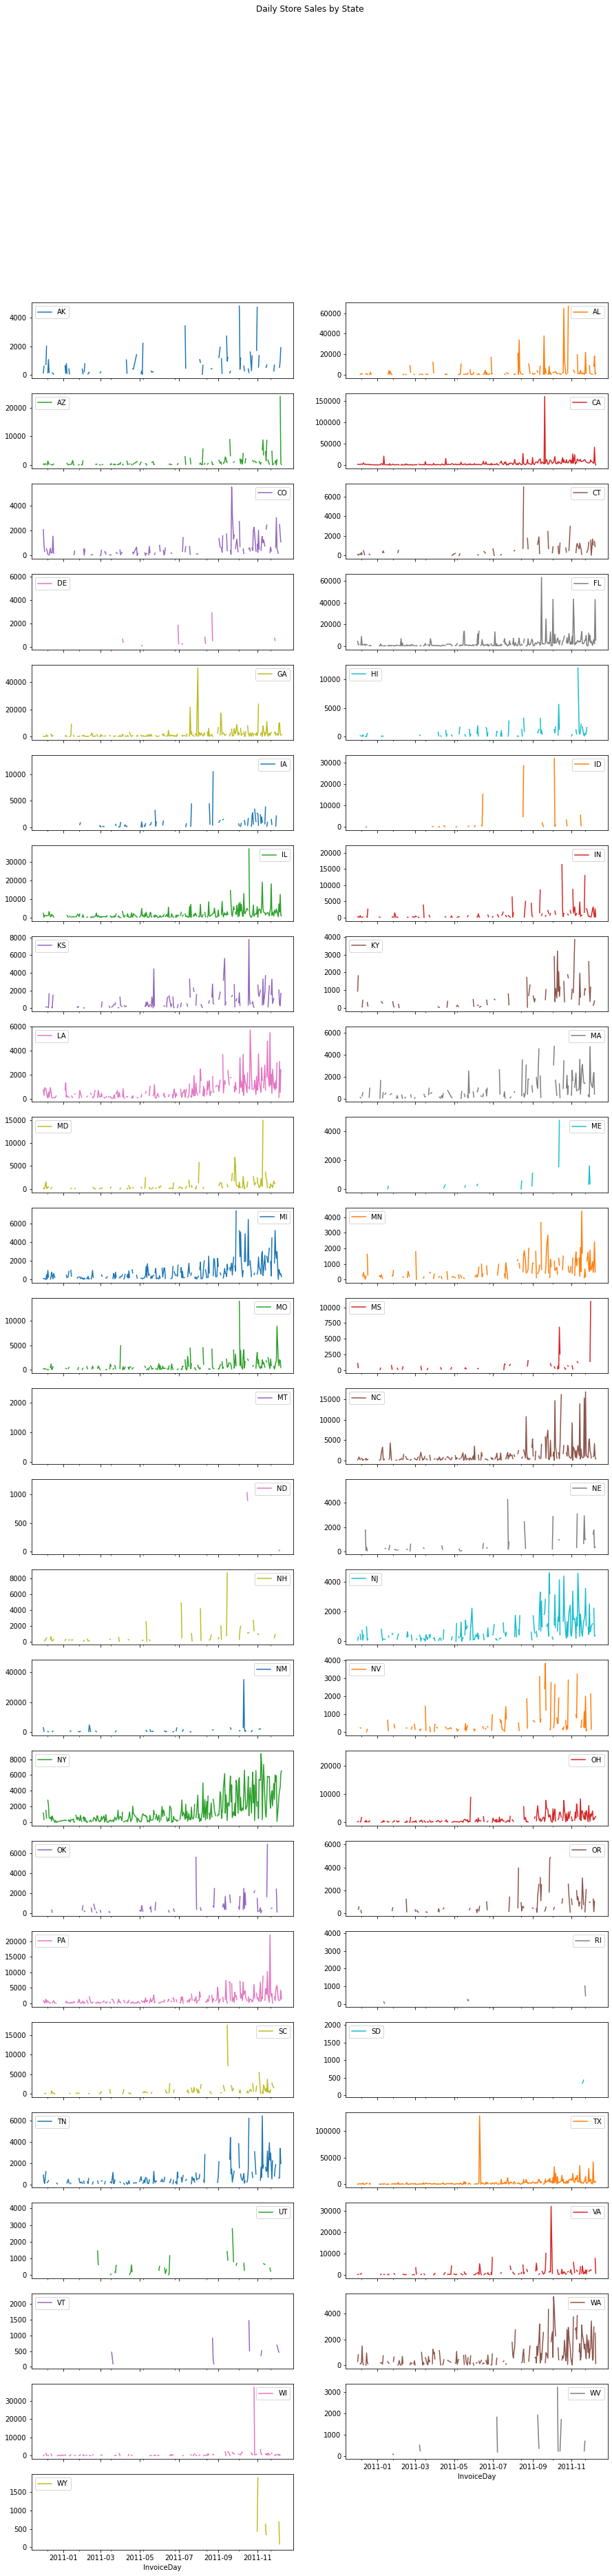

In [28]:
# plot store sales by state
df_sales[df_sales.Channel == 'Store']\
    .groupby(['State', 'InvoiceDay'])\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='State', values='Sales')\
    .plot(figsize=(15, 60), subplots=True, layout=(25, 2), title="Daily Store Sales by State");

Interestingly, it looks like all 49 states do have at least one store sale. And, for those with enough Store sales data for a decent plot, it seems as if store sales are trending upwards accross the board. In particular, some states like MN seem to be growing in sales quickly. For future analysis, it'd be interesting to break things down by the other channels, and by product category as well.

### Customer
Finally, let's take a quick look at sales volume by customer for the year.

In [42]:
# group sales by customer
df_cust = df_sales\
    .groupby('CustomerID')\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)
df_cust.sort_values('Sales', ascending=False, inplace=True)

# add PctTotalSales
df_cust['PctTotalSales'] = (df_cust.Sales / df_cust.Sales.sum()).round(6) * 100

In [41]:
df_cust.head(15)

,Sales,PctTotalSales
CustomerID,,
14646,635461.30,3.5358
17450,488648.59,2.7189
18102,484037.99,2.6932
14911,312340.27,1.7379
14156,253381.41,1.4098
12415,207121.29,1.1524
16029,195650.69,1.0886
17511,191561.66,1.0659
14096,191521.59,1.0656


In [48]:
# number of customers
df_cust.shape[0]

4293

In [50]:
# share of sales by top 1% of customers
df_cust.iloc[:43].PctTotalSales.sum()

31.407799999999998

In [49]:
# share of sales by top 5% of customers
df_cust.iloc[:215].PctTotalSales.sum()

49.50410000000001

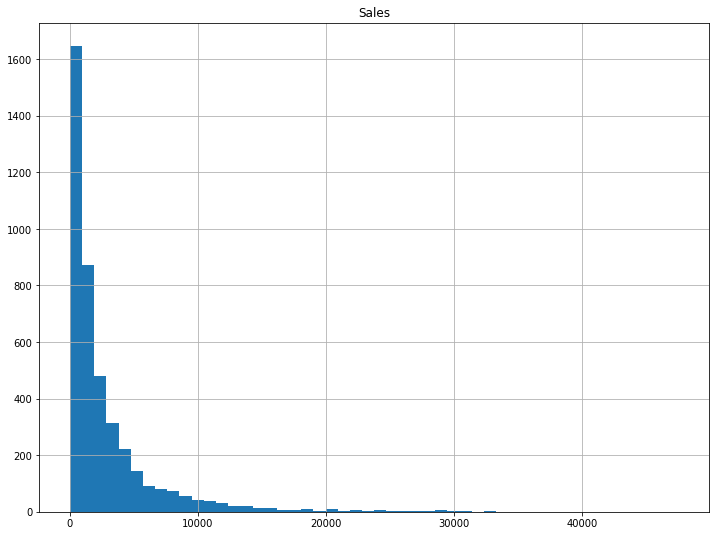

In [46]:
# hist of customer sales volumes where cust has spentn < 50,000bb
ax = df_cust[df_cust.Sales < 50000].hist('Sales', bins=50, figsize=(12, 9));

Some customers spend much more than others, with the top 1% customers responsible for 31.4% of the year's sales and the top 5% responsible for nearly half of all sales.

## Summary
Looking at sales by channel, it's clear that `Store` and `SEO` account for the majority of sales, at 56.82% and 28.40%, respectively. `Store` also accounts for the vast majority of sales growth for the year. `Store` growth has outpaced every other channel, with `Mailing` a close second. Though `SEO` is the second largest sales channel, it's unclear if `SEO` sales are trending upwards.

`Store` grew from 43% of sales in Q1 to 66.15% of sales in Q4, while `Mailing` also increased its share of total sales. They outpaced all other channels in growth between Q1 and Q4.

Sales by state are correlated with population size, which is expected. However, some states like AL have an unusually high proportion of sales given their population size. It would be interesting to investigate why this is.

And finally, some customers spend much more than others, with the top 1% customers responsible for 31.4% of the year's sales and the top 5% responsible for nearly half of all sales.